# Set up

In [2]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Voting Classifiers

In [3]:
heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

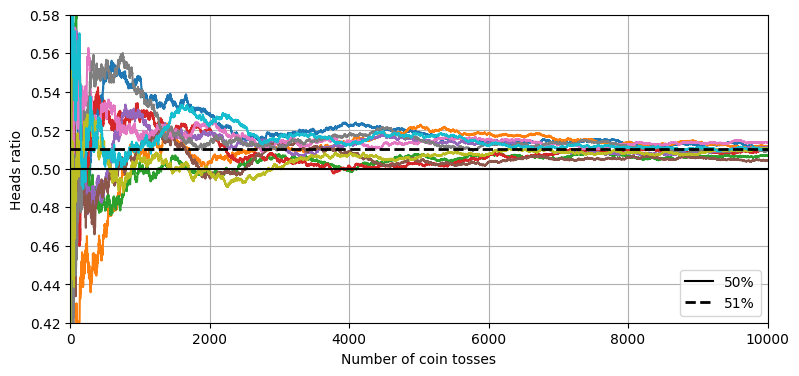

In [4]:
plt.figure(figsize=(9, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.axis([0, 10000, 0.42, 0.58])
plt.legend(loc="lower right")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.grid()
plt.show()

Here, we will build  a voting classifier.

In [5]:
from sklearn.datasets import make_moons
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you train `VotingClassifier`, it clones every estimators and fits the clones. The original estimators can be accessed via the `estimators` attribute, while the fitted estimators can be accessed via the `estimators_` attribute.

In [6]:
voting_clf.estimators

[('lr', LogisticRegression(random_state=42)),
 ('rf', RandomForestClassifier(random_state=42)),
 ('svc', SVC(random_state=42))]

In [7]:
voting_clf.estimators_

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 SVC(random_state=42)]

If you prefer a dict instead of a list, you can use the attribute `named_estimators_` instead.

In [8]:
voting_clf.named_estimators_

{'lr': LogisticRegression(random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [9]:
for name, classifier in voting_clf.named_estimators_.items():
    print(name, "=", classifier.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


When you call the voting classifier's method `predict`, it performs the hard voting. 

In [10]:
voting_clf.predict(X_test[:1])

array([1])

The voting classifier asks all of its estimators to predict the instance, then check which class gets the most votes.

In [11]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Let's see how it performs on the test set.

In [12]:
voting_clf.score(X_test, y_test)

0.912

And yes, the voting classifier outperform all the individual classifiers

You can use soft voting by setting the `voting` hyperparameter to `soft`. This will tell the model to estimate each individual's probabilities. In our case, the SVC don't estimate the probability by default, so you need to set its `probability=True`.

In [13]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting in Scikit-learn

You can use `BaggingClassifier` class for both bagging and pasting tasks. If you want to use pasting, just set `bootstrap=False`.

We will train 500 decision trees. Each of them is trained on 100 instances randomly sampled with replacement from the training dataset:
- `n_estimators`: The number of estimators
- `max_samples`: The max number of samples
- `n_jobs`: The number of CPU cores dedicated for the task, -1 means use all the possible cores.
- `bootstrap`: Default to True. If you want to use pasting instead of bagging, set it to False.

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

The `BaggingClassifier` uses soft voting instead of hard voting if the base classifier has a `predict_proba()` method (i.e. it can estimate the class probabilities), which is the case with decision tree classifiers.

In [15]:
def plot_decision_boundary(clf: sklearn.base.BaseEstimator, X, y, alpha=1.0):
    axes = [-1.5, 2.5, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_predict = clf.predict(X_new).reshape(x1.shape)

    plt.contour(x1, x2, y_predict, cmap="Greys", alpha=0.8 * alpha)
    plt.contourf(x1, x2, y_predict, cmap="Wistia", alpha=0.3 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ["o", "^"]
    for idx in [0, 1]:
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel("$x_1$")

In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

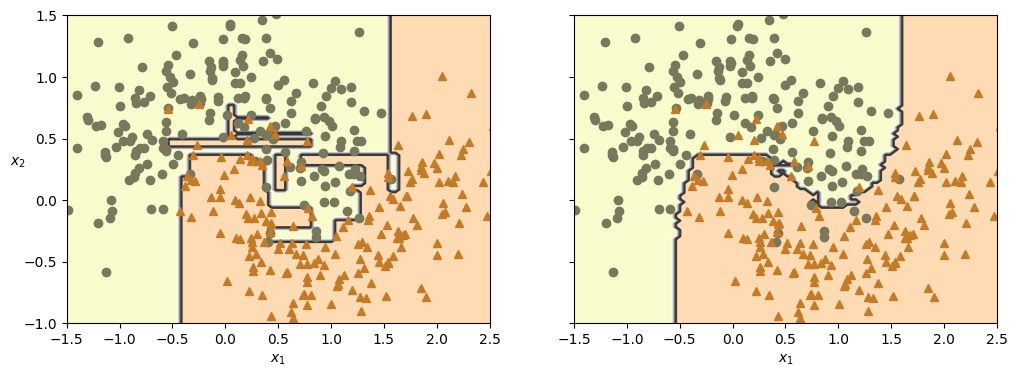

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.ylabel("$x_2$", rotation=0)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)

plt.show()

# Out-of-Bag Evaluation

You can set `oob_score=True` to have an automatic OOB evaluation after training. The result can be accessed via the `oob_score_` attribute.

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

Our model thinks its accuracy is about 89.6%. Let's see how it actually performs on the test set.

In [19]:
bag_clf.score(X_test, y_test)

0.92

Well, looks like our model is a bit pessimistic.

We can also ask for OOB decision function for each training instance, using the `oob_decision_function_` attribute. Because the base estimators has a `predict_proba()` method, the decision function returns the estimated probability for each instance.

In [20]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

# Random Forests

Here, we train a random forest with 500 decision trees, each with maximum 16 leaf nodes and utilize to use every possible CPUs.

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42
)

forest_clf.fit(X_train, y_train)
y_predict_forest = forest_clf.predict(X_test)

With a few exceptions, `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how the trees are grown) and all the hyperparameters from a `BaggingClassifier` to control the ensemble itself.

As explained in the note.md, this bagging classifier is equivalent to our previous random forest.

In [22]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42,
)

In [23]:
# Verify that bag_clf is indeed equivalent to forest_clf
bag_clf.fit(X_train, y_train)
y_predict_bag = bag_clf.predict(X_test)
np.all(y_predict_bag == y_predict_forest)

True

## Extra-Trees

You can have an extra-trees simply by setting `splitter="random"` in `DecisionTreeClassifier`.

In [24]:
BaggingClassifier(DecisionTreeClassifier(splitter="random"))

BaggingClassifier(estimator=DecisionTreeClassifier(splitter='random'))

There is an API for extra-trees in Scikit-learn, `ExtraTreesClassifier` class. Its hyperparameters is similar to `RandomForestClassifier`, expect `bootstrap=False` by default. Simlairly, there is `ExtraTreesRegressor` class for regression tasks.

In [25]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

ExtraTreesRegressor?

Init signature:
ExtraTreesRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=False,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
An extra-trees regressor.

This class implements a meta estimator that fits a number of
randomized decision trees (a.k.a. extra-trees) on various sub-samples
of the dataset and uses averaging to improve the predictive accuracy
and control over-fitting.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion : {"squared_error", "absol

In [26]:
ExtraTreesClassifier?

Init signature:
ExtraTreesClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=False,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
An extra-trees classifier.

This class implements a meta estimator that fits a number of
randomized decision trees (a.k.a. extra-trees) on various sub-samples
of the dataset and uses averaging to improve the predictive accuracy
and control over-fitting.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion : {"gin

## Features Importance

This code cell trains a random forest on the iris dataset and outputs each features' importances.

In [33]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
forest_clf = RandomForestClassifier(n_estimators=500, random_state=42)
forest_clf.fit(iris.data, iris.target)
for important, name in sorted(
    zip(forest_clf.feature_importances_, iris.data.columns), reverse=True
):
    print(round(important * 100, 3), "%", name)

44.103 % petal length (cm)
42.336 % petal width (cm)
11.249 % sepal length (cm)
2.312 % sepal width (cm)


So the most important features are petal length (44.1%) and petal width (42.3%), while sepal width (11.2%) and sepal length (2.3%) are not really important. This is also the reason why we only talk about petal length and petal width in previous notebooks.

Similarly, we consider the MNIST dataset and plot the importance of each pixel.

In [38]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml(
    "mnist_784", return_X_y=True, as_frame=True, parser="auto"
)

forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
forest_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(n_jobs=-1, random_state=42)

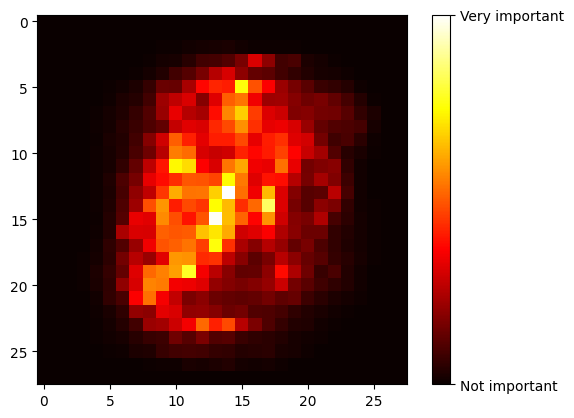

In [45]:
heatmap_image = forest_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
color_bar = plt.colorbar(
    ticks=[forest_clf.feature_importances_.min(), forest_clf.feature_importances_.max()]
)
color_bar.ax.set_yticklabels(["Not important", "Very important"])
plt.show()